# **TP09 - Modelo de lenguaje y Sistemas de Recomendación**

<p align=center>
    <img src="https://github.com/walteraguirre/TPS/blob/main/TP09/imagenes/ej_a.png?raw=true" alt="ej a">
<</p>>

In [16]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import io
import zipfile
import requests



## **Lectura de datos**

Lo primero que tenemos que hacer es cargar la base de datos correspondiente. En este caso la base de datos la obtenemos del archivo `movies.csv` que se encuentra en el Github de la materia.

El código realiza lo siguiente:

- `url`: contiene la dirección directa al archivo CSV alojado en un repositorio de GitHub.
- `pd.read_csv(url)`: carga el archivo CSV desde la URL y lo convierte en un `DataFrame` de `pandas` para el análisis de datos.
- `df_movies.head().to_markdown()`: muestra las primeras filas del DataFrame en formato Markdown para facilitar la visualización.

El DataFrame resultante representa una matriz de calificaciones usuario-película, donde:

- Cada **fila** corresponde a una **película**.
- Cada **columna** representa un **usuario**.
- Cada celda contiene información sobre la interacción del usuario con la película, es decir, que calificación le da el usuario a la pelicula, la calificación es un número entre 1 y 5, y puede ser 0 en caso de que el usuario todavía no haya calificado la pelicula.

In [17]:

# URL del archivo CSV en formato "raw" (crudo)
url = 'https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/movies.csv'

# Leer el archivo CSV directamente desde GitHub
df_movies = pd.read_csv(url)

# Mostrar las primeras filas del DataFrame
print(df_movies.head().to_markdown())


|    | Name              |   user_0 |   user_1 |   user_2 |   user_3 |   user_4 |   user_5 |   user_6 |   user_7 |   user_8 |   user_9 |   user_10 |   user_11 |   user_12 |   user_13 |   user_14 |   user_15 |   user_16 |   user_17 |   user_18 |   user_19 |   user_20 |   user_21 |   user_22 |   user_23 |   user_24 |   user_25 |   user_26 |   user_27 |   user_28 |   user_29 |   user_30 |   user_31 |   user_32 |   user_33 |   user_34 |   user_35 |   user_36 |   user_37 |   user_38 |   user_39 |   user_40 |   user_41 |   user_42 |   user_43 |   user_44 |   user_45 |   user_46 |   user_47 |   user_48 |   user_49 |   user_50 |   user_51 |   user_52 |   user_53 |   user_54 |   user_55 |   user_56 |   user_57 |   user_58 |   user_59 |   user_60 |   user_61 |   user_62 |   user_63 |   user_64 |   user_65 |   user_66 |   user_67 |   user_68 |   user_69 |   user_70 |   user_71 |   user_72 |   user_73 |   user_74 |   user_75 |   user_76 |   user_77 |   user_78 |   user_79 |   user_80 |   user_81 |

## **Carga del modelo de lenguaje GloVe**

Se carga un modelo de lenguaje preentrenado basado en GloVe (*Global Vectors for Word Representation*), una técnica que permite representar palabras como vectores numéricos en un espacio semántico.

El archivo `glove.6B.300d.txt` contiene vectores de 300 dimensiones para un vocabulario extenso. Se lee línea por línea, separando la palabra del vector correspondiente. Cada vector se guarda como un array de `numpy`, y se construye un diccionario donde las claves son palabras y los valores son sus vectores.

Para ello:

- Se abre el archivo con codificación `utf-8`.
- Cada línea se separa en partes: la primera es la palabra, las siguientes 300 son los valores numéricos del vector.
- Se convierte ese fragmento numérico en un `np.array` de tipo `float`.
- Se guarda la entrada en un diccionario llamado `language_model`.

Este modelo permite capturar relaciones semánticas entre palabras y se puede utilizar para construir representaciones vectoriales de títulos de películas y comparar su similitud, incluso cuando haya errores de tipeo o palabras omitidas.



In [18]:
# URL del archivo GloVe
url = 'http://nlp.stanford.edu/data/glove.6B.zip'

# Descarga del ZIP en memoria
print("Descargando GloVe...")
resp = requests.get(url)
resp.raise_for_status()
zip_buf = io.BytesIO(resp.content)
print("Descarga completa")



Descargando GloVe...
Descarga completa


In [19]:
# Inicializamos el diccionario
language_model = {}

# Leemos el archivo glove.6B.300d.txt desde el ZIP
print("Cargando embeddings glove.6B.300d.txt...")
with zipfile.ZipFile(zip_buf) as z:
    with z.open('glove.6B.300d.txt') as f:
        for line in f:
            parts = line.decode('utf-8').strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=float)
            language_model[word] = vec

print(f"Modelo cargado: {len(language_model):,} palabras.")


Cargando embeddings glove.6B.300d.txt...
Modelo cargado: 400,000 palabras.


## **Buscador de películas**

En esta sección se define una clase `BuscadorPeliculas` que permite buscar películas a partir de una consulta en lenguaje natural. Para lograrlo, se usan **embeddings de palabras** obtenidos del modelo de lenguaje GloVe.

La idea central es convertir tanto los títulos de películas como la consulta del usuario en vectores, y luego buscar el título más similar usando la **similitud coseno**.

La clase recibe:

- `titulos_peliculas`: una lista con los nombres de las películas.
- `modelo_lenguaje`: un diccionario que asocia cada palabra a su vector GloVe.
- `dimension`: la dimensión de los vectores (300 por defecto).

Durante la inicialización, se convierte cada título en un vector mediante una función de tipo "bolsa de palabras".

Los métodos de la clase son: 

- `word2vec(palabra)`: devuelve el vector correspondiente a una palabra. Si no está en el vocabulario, retorna un vector nulo.
  
- `bolsa_de_palabras(texto)`: transforma un texto en un vector promedio. Este vector representa el título completo o la consulta del usuario. El procesamiento incluye:

  1. **Minúsculas**: convierte todo el texto a minúsculas para evitar que las mayúsculas afecte la comparación.
  2. **Remoción de símbolos**: elimina caracteres no alfanuméricos como signos de puntuación.
  3. **Espacios extra**: quita los espacios en blanco extras.
  4. **Separación por palabras**: divide el texto en palabras individuales.
  5. **Conversión a vectores**: convierte cada palabra en su vector GloVe correspondiente.
  6. **Promedio**: calcula el promedio de los vectores individuales para obtener un único vector que representa el texto completo.

  Por ejemplo:
  Supongamos que el título es `"Toy Story (1995)"`. El procesamiento se hace así:

  - Se convierte a minúsculas: `"toy story (1995)"`
  - Se eliminan símbolos no alfanuméricos: `"toy story 1995"`
  - Se remueven espacios extra (en este caso no aplica)
  - Se divide en palabras: `["toy", "story", "1995"]`
  - Cada palabra se convierte en un vector, y luego se promedian para formar un único vector de dimensión 300.

  Este vector es el que se usará para comparar contra otros títulos o contra la consulta del usuario.

  
- `similitud_coseno(u, v)`: calcula la similitud entre dos vectores usando el coseno del ángulo entre ellos. Esta métrica se define como:

  $$
  \text{sim}(u, v) = \frac{u \cdot v}{\|u\| \cdot \|v\|}
  $$

  Donde $ u \cdot v $ es el producto punto entre los vectores, y $ \|u\| $ y $ \|v\| $ son sus normas. Si alguno de los vectores es nulo (norma cero), la similitud se define como cero.

- `buscar(consulta)`: convierte la consulta en un vector y lo compara con todos los vectores de títulos. Devuelve el título más similar y su puntuación de similitud.


In [ ]:
class BuscadorPeliculas:
    def __init__(self, titulos_peliculas, modelo_lenguaje, dimension=300):
        self.modelo_lenguaje = modelo_lenguaje
        self.dimension = dimension
        self.titulos = titulos_peliculas
        self.embeddings_titulos = [self.bolsa_de_palabras(t) for t in self.titulos]

    def word2vec(self, palabra):
        #Devuelve el vector correspondiente a una palabra o un vector cero si no está.
        return self.modelo_lenguaje.get(palabra, np.zeros(self.dimension))

    def bolsa_de_palabras(self, texto):
        texto = texto.lower() #pasamos todo a minúsculas
        texto = re.sub(r'[^a-z0-9\s]', '', texto) #eliminamos caracteres no alfanumericos
        texto = re.sub(r'\s+', ' ', texto).strip() #elimina espacios extras
        palabras = texto.split() #separa por palabras
        vectores = [self.word2vec(p) for p in palabras] #obtiene los vectores para cada palabra
        return np.mean(vectores, axis=0) if vectores else np.zeros(self.dimension) #devuelve la media de los vectores

    def similitud_coseno(self, u, v):
        # Calcula la similitud coseno entre dos vectores.
        norma_u = np.linalg.norm(u)
        norma_v = np.linalg.norm(v)
        if norma_u == 0 or norma_v == 0:
            return 0.0
        return np.dot(u, v) / (norma_u * norma_v)

    def buscar(self, consulta):
        #Busca el título más similar a la consulta ingresada.
        emb_consulta = self.bolsa_de_palabras(consulta)
        similitudes = [self.similitud_coseno(emb_consulta, emb_t) for emb_t in self.embeddings_titulos]
        indice_max = np.argmax(similitudes)
        return self.titulos[indice_max], similitudes[indice_max]
    

# Crear el buscador
buscador = BuscadorPeliculas(df_movies['Name'].tolist(), language_model)


### **Prueba del método `word2vec`**

Se testea el método `word2vec`, encargado de convertir una palabra en su correspondiente vector GloVe. Este método busca la palabra en el modelo de lenguaje y devuelve su vector de 300 dimensiones. En caso de que la palabra no se encuentre en el vocabulario, se devuelve un vector de ceros.

En esta prueba:

- Se consulta la palabra `"story"` que sí está en el modelo, y se imprimen las primeras 5 componentes de su vector.
- Luego se consulta una palabra inexistente (`"aaskdkasd"`) para verificar que el método devuelva correctamente un vector nulo.

Este test confirma que el método funciona correctamente en ambos casos: tanto para palabras presentes como ausentes en el vocabulario del modelo.


In [21]:

# --- Test método word2vec ---
palabra = "story"
vector1 = buscador.word2vec(palabra)
print("Vector de 'story' (primeras 5 componentes):", vector1[:5])

palabra_inexistente = "aaskdkasd"
vector_inexistente = buscador.word2vec(palabra_inexistente)
print("Vector de 'aaskdkasd' (palabra inexistente):", vector_inexistente[:5])


Vector de 'story' (primeras 5 componentes): [-0.20664 -0.1377  -0.11119 -0.45468  0.26058]
Vector de 'aaskdkasd' (palabra inexistente): [0. 0. 0. 0. 0.]


### 🔹 Prueba del método `bolsa_de_palabras`

Se evalúa el funcionamiento del método `bolsa_de_palabras` de la clase `BuscadorPeliculas`.

Primero, se calcula el vector de la frase `"Toy Story"` completa, que debería ser el resultado de promediar los vectores de cada una de sus palabras.

Luego, se obtienen los vectores de las palabras `"Toy"` y `"Story"` por separado. Posteriormente, se calcula el promedio de estos dos vectores individuales y se compara con el vector obtenido directamente de la frase completa.

Finalmente, se utiliza la función `np.allclose()` para verificar si ambos vectores son prácticamente iguales. Esto sirve como validación de que el método está funcionando correctamente.



In [22]:

# --- Test método bolsa_de_palabras ---
frase_completa = "Toy Story"
vector_frase_completa = buscador.bolsa_de_palabras(frase_completa)
print("\nVector de 'Toy Story' (primeras 5 componentes):", vector_frase_completa[:5])

print("\nObtenemos los vectores de las palabras por separado para ver si dan el mismo resultado")
vector1 = buscador.bolsa_de_palabras("Toy")
vector2 = buscador.bolsa_de_palabras("Story")

print(f"Vector de 'Toy' (primeras 5 compontes): {vector1[:5]} \n")
print(f"Vector de 'Story' (primeras 5 compontes): {vector2[:5]} \n")
print(f"Promedio entre los dos (primeras 5 componentes): {(vector1[:5]+vector2[:5])/2}")

es_igual = np.allclose(vector_frase_completa, (vector1 + vector2) / 2)
print(f"¿Coinciden los vectores?: {es_igual}")





Vector de 'Toy Story' (primeras 5 componentes): [ 0.02109   0.102155 -0.237945 -0.43965  -0.11878 ]

Obtenemos los vectores de las palabras por separado para ver si dan el mismo resultado
Vector de 'Toy' (primeras 5 compontes): [ 0.24882  0.34201 -0.3647  -0.42462 -0.49814] 

Vector de 'Story' (primeras 5 compontes): [-0.20664 -0.1377  -0.11119 -0.45468  0.26058] 

Promedio entre los dos (primeras 5 componentes): [ 0.02109   0.102155 -0.237945 -0.43965  -0.11878 ]
¿Coinciden los vectores?: True


Podemos observar que el método implementado para la bolsa de palabras está funcionando bien.

### 🔹 Prueba del método `similitud_coseno` entre pares de consultas

Primero se define la función `probar_sim_coseno`, cuyo objetivo es comparar distintos pares de frases utilizando la similitud coseno entre sus vectores representados mediante el método `bolsa_de_palabras`.

La función realiza lo siguiente:

1. **Entrada:** recibe una instancia del buscador (`BuscadorPeliculas`) y una lista de pares de frases (`pares_consultas`).
2. **Proceso:**
   - Para cada par de frases, convierte ambas en vectores usando `bolsa_de_palabras`.
   - Calcula la similitud coseno entre estos vectores con el método `similitud_coseno`.
   - Muestra en consola la similitud obtenida.

#### Casos de prueba incluidos

Los pares de frases están pensados para evaluar diferentes aspectos del preprocesamiento y la representación semántica:

- **Mayúsculas vs minúsculas:** se espera una similitud cercana a 1 ya que la el método bolsa de palabras debería transformar todo a minúsculas.
- **Espacios extra:** verifica que los espacios adicionales no afecten el resultado.
- **Errores ortográficos:** observa cómo pequeñas modificaciones ortográficas afectan la similitud.
- **Palabras con significado similar:** mide si el modelo capta cierta relación semántica (como "king" y "queen").
- **Títulos con información adicional:** compara títulos con y sin año (`"Toy Story"` vs `"Toy Story (1995)"`).
- **Palabras inexistentes en el vocabulario:** muestra que la similitud puede ser baja o nula si las palabras no están en GloVe.

Este análisis nos permite comprobar el funcionamiento del sistema de búsqueda y verificar qué tan robusto es ante errores, variaciones tipográficas o semánticas.


In [23]:

# --- Test método similitud_coseno ---

def probar_sim_coseno(buscador, pares_consultas):
    """
    Calcula y muestra la similitud coseno entre pares de consultas.

    Parámetros:
    - buscador: instancia de la clase BuscadorPeliculas.
    - pares_consultas: Lista de pares de strings (consulta1, consulta2).
    """
    print("\n🔍 Comparación de similitud coseno entre pares de consultas:\n")
    for i, (texto1, texto2) in enumerate(pares_consultas, 1):
        vec1 = buscador.bolsa_de_palabras(texto1)
        vec2 = buscador.bolsa_de_palabras(texto2)
        sim = buscador.similitud_coseno(vec1, vec2)
        print(f"{i}. '{texto1}' vs '{texto2}' → similitud: {sim:.4f}")

pares_prueba = [
    # Mayúsculas vs minúsculas -> deberia dar una SC cercana a 1
    ("Toy Story", "toy story"),

    # Espacios en blanco extra
    ("  The Matrix", "The Matrix  "),
    ("Interstellar", "Inter   stellar"),

    # Errores ortográficos
    ("The Lion King", "The Loin King"),
    ("finding nemo", "fnding nemo"),

    # Palabras similares o sinónimos
    ("king", "queen"),
    ("fast car", "speed vehicle"),

    # Títulos iguales pero con año -> deberia dar una SC cercana a 1
    ("Toy Story", "Toy Story (1995)"),

    # Palabras fuera del vocabulario (pueden dar similitud baja o cero)
    ("abcdefgh", "xyz123"),
]


probar_sim_coseno(buscador, pares_prueba)





🔍 Comparación de similitud coseno entre pares de consultas:

1. 'Toy Story' vs 'toy story' → similitud: 1.0000
2. '  The Matrix' vs 'The Matrix  ' → similitud: 1.0000
3. 'Interstellar' vs 'Inter   stellar' → similitud: 0.1524
4. 'The Lion King' vs 'The Loin King' → similitud: 0.7460
5. 'finding nemo' vs 'fnding nemo' → similitud: 0.8435
6. 'king' vs 'queen' → similitud: 0.6336
7. 'fast car' vs 'speed vehicle' → similitud: 0.7458
8. 'Toy Story' vs 'Toy Story (1995)' → similitud: 0.9045
9. 'abcdefgh' vs 'xyz123' → similitud: 0.0000


### **Conclusiones de la similitud coseno**

A partir de los resultados obtenidos al comparar distintos pares de consultas, se pueden sacar las siguientes conclusiones:

#### Robustez ante diferencias superficiales

1. **'Toy Story' vs 'toy story' → 1.0000**
2. **'  The Matrix' vs 'The Matrix  ' → 1.0000**

Estos casos muestran que el sistema es insensible a mayúsculas, minúsculas y espacios en blanco adicionales, lo cual es ideal para un buscador de texto.

---

#### Sensibilidad a separación de palabras

3. **'Interstellar' vs 'Inter   stellar' → 0.1524**

La separación de la palabra "Interstellar" en dos partes distintas produce una caída importante en la similitud. Esto refleja una limitación típica de los modelos de bolsa de palabras, que no logran identificar correctamente palabras compuestas mal segmentadas.

---

#### Tolerancia a errores ortográficos

4. **'The Lion King' vs 'The Loin King' → 0.7460**
5. **'finding nemo' vs 'fnding nemo' → 0.8435**

Esto muestra que el modelo tiene cierta tolerancia a errores ortográficos leves, especialmente cuando el resto del contenido sigue siendo identificable.

---

#### Capacidad semántica básica

6. **'king' vs 'queen' → 0.6336**
7. **'fast car' vs 'speed vehicle' → 0.7458**

Estos resultados muestran que el sistema puede capturar cierta relación semántica entre palabras relacionadas (como sinónimos o conceptos cercanos), aunque sin un entendimiento profundo. Esto es esperable en representaciones como GloVe, que se basan en coocurrencias en textos.

---

#### Tolerancia a información adicional

8. **'Toy Story' vs 'Toy Story (1995)' → 0.9045**

Agregar un año en paréntesis reduce levemente la similitud, pero no la elimina, lo que sugiere que el modelo maneja bien los datos adicionales que suelen encontrarse en títulos, como fechas o numeraciones.

---

#### Palabras fuera del vocabulario

9. **'abcdefgh' vs 'xyz123' → 0.0000**

Ambos términos no existen en el vocabulario del modelo, por lo que sus vectores son nulos, y la similitud es exactamente cero. Esto confirma que el sistema no puede manejar correctamente entradas completamente desconocidas o no lingüísticas.

---

El sistema basado en bolsa de palabras con vectores preentrenados (como GloVe) presenta buen desempeño ante variaciones menores en el texto (mayúsculas, espacios, paréntesis) y cierta capacidad para capturar similitudes semánticas. Sin embargo, muestra limitaciones ante errores ortográficos graves, separación inusual de palabras y entradas fuera del vocabulario. Estas observaciones son útiles para entender tanto las fortalezas como las restricciones del modelo.

---


## **Sistemas de recomendación**

<p align=center>
    <img src="https://github.com/walteraguirre/TPS/blob/main/TP09/imagenes/ej_b.png?raw=true" alt="ej b">
</p>

## **Agregar un nuevo usuario al sistema de recomendación**

Esta función permite simular la interacción de un nuevo usuario con el sistema de recomendación. A partir de una serie de consultas escritas a mano (que pueden contener errores tipográficos o ser diferentes a los títulos originales), y una serie de calificaciones numéricas, se agrega una nueva columna al `DataFrame` original. Cada fila representa una película, y cada columna un usuario, por lo que estamos agregando las preferencias personalizadas de este nuevo usuario.

La función `agregar_usuario()` funciona de la siguiente manera:

- Se crea una copia del `DataFrame` para evitar modificar el original.
- Se agrega una nueva columna (con el nombre del usuario) inicializada en cero, es decir, sin ninguna calificación asignada todavía.
- Luego se recorre cada consulta hecha por el usuario. Para cada una:
  - Se utiliza el objeto `BuscadorPeliculas` (definido anteriormente) para buscar el título más similar.
  - Si el título encontrado existe en el `DataFrame`, se coloca la calificación correspondiente en la fila adecuada.
  - Si no se encuentra, se imprime un mensaje de advertencia.

La función devuelve un nuevo `DataFrame` que incluye esta columna adicional con las calificaciones del usuario.


In [24]:
def agregar_usuario(df, buscador, nombre_usuario, consultas, calificaciones):

    # Copia del DataFrame para no modificar el original
    df_actualizado = df.copy()

    # se crea una nueva columna llena de ceros
    df_actualizado[nombre_usuario] = 0

    # iteramos sobre las consultas
    for consulta, calif in zip(consultas, calificaciones):

        #obtenemos el titulo a partir de la consulta
        titulo_encontrado, similitud = buscador.buscar(consulta)
        print(f"Consulta: '{consulta}' → Encontrado: '{titulo_encontrado}' (similitud: {similitud:.3f})")

        #si el titulo encontrado se encuentra en el Dataframe, asignamos su calificación
        if titulo_encontrado in df_actualizado['Name'].values:  
            fila_idx = df_actualizado[df_actualizado['Name'] == titulo_encontrado].index[0]
            df_actualizado.at[fila_idx, nombre_usuario] = calif
        
        #si no está, imprimimos un mensaje.
        else:
            print(f" '{titulo_encontrado}' no está en la columna de títulos.")


    return df_actualizado


# definimos pares (cosulta, clasificación)
consultas_y_calificaciones = [
    ("lion king",           4),
    ("the godfather",       5),
    ("batman",              4),
    ("goldeneye",          3),
    ("pulp fiction",        5),
    ("forrest gump",        5),
    ("star wars ",          4),
    ("braveheart",           4),
    ("bad boys",           3),
    ("Titanic",             5)
]


# Agregamos un nuevo usuario al DataFrame
df_actualizado = agregar_usuario(df_movies, buscador, "usuario_nuevo", [c for c, _ in consultas_y_calificaciones], [r for _, r in consultas_y_calificaciones])

# Verificamos los resultados
print(df_actualizado["usuario_nuevo"].value_counts())



Consulta: 'lion king' → Encontrado: ' Lion King, The (1994)' (similitud: 0.847)
Consulta: 'the godfather' → Encontrado: ' Godfather, The (1972)' (similitud: 0.879)
Consulta: 'batman' → Encontrado: ' Batman (1989)' (similitud: 0.805)
Consulta: 'goldeneye' → Encontrado: ' GoldenEye (1995)' (similitud: 0.838)
Consulta: 'pulp fiction' → Encontrado: ' Pulp Fiction (1994)' (similitud: 0.925)
Consulta: 'forrest gump' → Encontrado: ' Forrest Gump (1994)' (similitud: 0.922)
Consulta: 'star wars ' → Encontrado: ' Star Wars (1977)' (similitud: 0.923)
Consulta: 'braveheart' → Encontrado: ' Braveheart (1995)' (similitud: 0.811)
Consulta: 'bad boys' → Encontrado: ' Bad Boys (1995)' (similitud: 0.913)
Consulta: 'Titanic' → Encontrado: ' Titanic (1997)' (similitud: 0.816)
usuario_nuevo
0    1672
4       4
5       4
3       2
Name: count, dtype: int64


# Filtro colaborativo

En el filtrado colaborativo mediante factorización matricial, el objetivo es aproximar la matriz de calificaciones $ Y \in \mathbb{R}^{n_{\text{items}} \times n_{\text{users}}} $ como el producto de dos matrices de menor dimensión:

$$
\hat{Y} \approx X \Theta^\top
$$

- $ X \in \mathbb{R}^{n_{\text{items}} \times \nu} $: vectores latentes de los ítems (en este caso, películas).
- $ \Theta \in \mathbb{R}^{n_{\text{users}} \times \nu} $: vectores latentes de los usuarios.
- $ \nu $: dimensión del espacio latente (típicamente $ \nu \ll n_{\text{items}}, n_{\text{users}} $).

El entrenamiento consiste en minimizar una función de pérdida regularizada que penaliza tanto el error de predicción como la complejidad de los vectores:

$$
\min_{X, \Theta} \quad \frac{1}{2} \sum_{(i,j): y_{ij} > 0} \left( \theta_j^T x_i - y_{ij} \right)^2 + \frac{\lambda}{2} \left( \sum_{i=1}^{n_{\text{items}}} \|x_i\|^2 + \sum_{j=1}^{n_{\text{users}}} \|\theta_j\|^2 \right)
$$

- El primer término mide el error cuadrático en las observaciones reales.
- El segundo es la **regularización L2**, que penaliza vectores grandes y reduce el overfitting.
- $ \lambda \geq 0 $: hiperparámetro de regularización.


Para minimizar la función de pérdida usamos descenso del gradiente. Los gradientes de la función con respecto a los parámetros son:

### Gradiente respecto a los vectores de ítem $ x_i $:

$$
\frac{\partial J}{\partial x_i} = \sum_{j: y_{ij} > 0} \left( \theta_j^T x_i - y_{ij} \right) \theta_j + \lambda x_i
$$

### Gradiente respecto a los vectores de usuario $ \theta_j $:

$$
\frac{\partial J}{\partial \theta_j} = \sum_{i: y_{ij} > 0} \left( \theta_j^T x_i - y_{ij} \right) x_i + \lambda \theta_j
$$


En cada iteración se actualizan los parámetros de la siguiente forma:

$$
x_i \leftarrow x_i - \eta \cdot \frac{\partial J}{\partial x_i}
\qquad
\theta_j \leftarrow \theta_j - \eta \cdot \frac{\partial J}{\partial \theta_j}
$$

donde $ \eta $ es la tasa de aprendizaje.

---

##  **Implementación**

Se implementó una clase llamada `FiltroColaborativo`, que encapsula todo el comportamiento necesario para entrenar y utilizar un sistema de recomendación basado en filtrado colaborativo mediante factorización matricial con descenso por gradiente y regularización L2.

Como mencionamos previamente, la idea central es aproximar la matriz de calificaciones $ Y $ como el producto de dos matrices latentes de menor dimensión:

$$
Y \approx X \Theta^\top
$$

donde:
- $ X \in \mathbb{R}^{n_{\text{items}} \times k} $ es la matriz de embeddings de ítems (películas).
- $ \Theta \in \mathbb{R}^{n_{\text{usuarios}} \times k} $ es la matriz de embeddings de usuarios.
- $ k $ es la dimensión del espacio latente.


La clase inicializa el modelo con los siguientes hiperparámetros:
- `k`: dimensión del espacio latente.
- `lambda_reg`: coeficiente de regularización L2.
- `lr`: tasa de aprendizaje.
- `num_iter`: número de iteraciones de entrenamiento.

Además, define como atributos internos:
- `X`: matriz de embeddings de ítems (inicializada en el entrenamiento).
- `Theta`: matriz de embeddings de usuarios.
- `errores`: lista con la evolución del error a lo largo del entrenamiento.


### `fit(Y)`  
Este método realiza el entrenamiento del modelo, recibiendo como entrada una matriz `Y` de calificaciones (donde los ceros representan valores ausentes). El proceso se desarrolla en varias etapas:

- **Inicialización aleatoria**  
  Se inicializan las matrices `X` y `Theta` con valores aleatorios pequeños provenientes de una distribución normal.

- **Máscara de observación**  
  Se genera una máscara booleana `mask` que indica dónde hay calificaciones reales en `Y`.

- **Bucle de optimización**  
  Durante `num_iter` iteraciones:
  
  - Se calcula la matriz de predicciones:
    $$
    \hat{Y} = X \Theta^T
    $$
  
  - Se calcula el error observado, aplicando la máscara para ignorar entradas ausentes:
    $$
    error = (Y - \hat{Y}) \odot mask
    $$

  - Se computan los gradientes del error regularizado respecto a `X` y `Theta`.

  - Se actualizan los parámetros usando descenso por gradiente:
    $$
    X \leftarrow X - \eta \cdot \nabla_X
    \quad\text{y}\quad
    \Theta \leftarrow \Theta - \eta \cdot \nabla_\Theta
    $$

  - Se evalúa el riesgo regularizado empírico:
    $$
    J = \frac{1}{2} \sum_{i,j: y_{ij}>0} (y_{ij} - \theta_j^\top x_i)^2 + \frac{\lambda}{2} \left( \|X\|^2 + \|\Theta\|^2 \right)
    $$

  - Este valor se guarda en `self.errores` para monitorear la convergencia del algoritmo.


### `predict(usuario_idx=None)`  
Devuelve la matriz completa de predicciones $ \hat{Y} = X \Theta^\top $, o solo la columna correspondiente a un usuario si se especifica su índice.

Esto permite recuperar las predicciones personalizadas para un usuario y ordenarlas para recomendarle las películas mejor valoradas que aún no haya visto.

---

### `graficar_error()`  
Este método grafica la evolución del riesgo regularizado a lo largo de las iteraciones de entrenamiento. Es útil para verificar si el modelo converge y ajustar hiperparámetros en caso contrario.


Iteración 0: Error = 687779.09
Iteración 100: Error = 85981.79
Iteración 200: Error = 74561.32
Iteración 300: Error = 73711.04
Iteración 400: Error = 73407.94
Iteración 500: Error = 73259.36
Iteración 600: Error = 73176.69
Iteración 700: Error = 73126.53
Iteración 800: Error = 73094.37
Iteración 900: Error = 73073.07
Iteración 1000: Error = 73058.70
Iteración 1100: Error = 73048.86
Iteración 1200: Error = 73042.04
Iteración 1300: Error = 73037.26
Iteración 1400: Error = 73033.83
Iteración 1500: Error = 73031.33
Iteración 1600: Error = 73029.46
Iteración 1700: Error = 73028.02
Iteración 1800: Error = 73026.89
Iteración 1900: Error = 73025.98


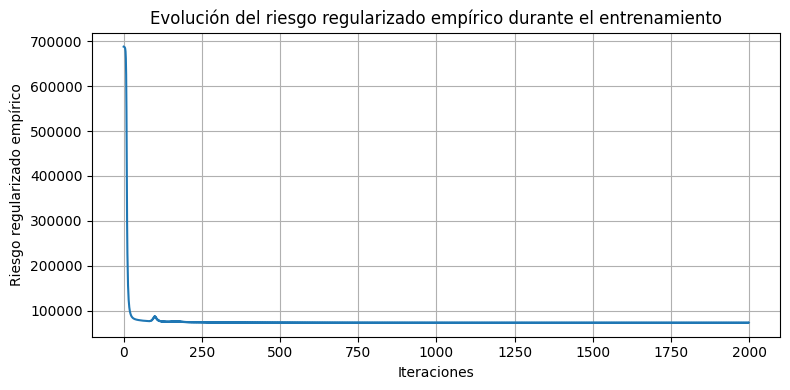

In [25]:
class FiltroColaborativo:
    def __init__(self, k=10, lambda_reg=10, lr=1e-3, num_iter=2000):
        """
        Inicializa el modelo de filtrado colaborativo.

        Args:
            k (int): Dimensión del espacio latente.
            lambda_reg (float): Término de regularización L2.
            lr (float): Tasa de aprendizaje.
            num_iter (int): Número de iteraciones de entrenamiento.
        """
        self.k = k
        self.lambda_reg = lambda_reg
        self.lr = lr
        self.num_iter = num_iter

        self.X = None
        self.Theta = None
        self.errores = []

    def fit(self, Y):
        """
        Entrena el modelo con la matriz de calificaciones Y.

        Args:
            Y (np.ndarray): matriz (n_items x n_users) con calificaciones, contiene ceros donde no hay calificación.
        """
        n_items, n_users = Y.shape

        # inicializamos X y Theta
        self.X = np.random.normal(scale=0.1, size=(n_items, self.k))
        self.Theta = np.random.normal(scale=0.1, size=(n_users, self.k))
        self.errores = []

        # obtenemos la mascara (matriz que tendrá 1 donde hay calificaciones y 0 donde no hay calificaciones aún)
        mask = Y > 0  

        for it in range(self.num_iter):
            
            #calculamos la prediccion de calificaciones 
            Y_hat = self.X @ self.Theta.T

            #computamos el error considerando solo las posiciones donde hay calificaciones validas
            error = (Y - Y_hat) * mask

            #calculamos los gradientes
            X_grad = -error @ self.Theta + self.lambda_reg * self.X
            Theta_grad = -error.T @ self.X + self.lambda_reg * self.Theta

            #actualizamos X y Theta
            self.X -= self.lr * X_grad
            self.Theta -= self.lr * Theta_grad

            #computamos la función de perdida
            loss = 0.5 * np.sum(error**2) + 0.5 * self.lambda_reg * (np.sum(self.X**2) + np.sum(self.Theta**2))
            self.errores.append(loss)

            if it % 100 == 0:
                print(f"Iteración {it}: Error = {loss:.2f}")

    def predict(self, usuario_idx=None):
        """
        Devuelve las predicciones completas o solo para un usuario.

        Args:
            usuario_idx (int or None): índice del usuario para obtener predicciones individuales.

        Returns:
            np.ndarray: matriz de predicciones (o vector si usuario_idx está especificado).
        """

        if self.X is None or self.Theta is None:
            raise ValueError("El modelo debe ser entrenado antes de predecir.")
        
        predicciones = self.X @ self.Theta.T

        if usuario_idx is not None:
            return predicciones[:, usuario_idx]
        
        return predicciones

    def graficar_loss(self):
        """Grafica la evolución del riesgo empirico durante el entrenamiento."""

        if not self.errores:
            print("El modelo aún no fue entrenado.")
            return
        
        plt.figure(figsize=(8, 4))
        plt.plot(self.errores)
        plt.xlabel("Iteraciones")
        plt.ylabel("Riesgo regularizado empírico")
        plt.title("Evolución del riesgo regularizado empírico durante el entrenamiento")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



# obtenemos la matriz Y desde el DataFrame
Y = df_actualizado.drop(columns=["Name"]).values.astype(float)

# Creamos y entrenamos el modelo
modelo_filtro = FiltroColaborativo(k=10, lambda_reg=10, lr=1e-3, num_iter=2000)
modelo_filtro.fit(Y)

# Mostramos la evolución del error
modelo_filtro.graficar_loss()



Se puede ver en el gráfico que el riesgo regularizado empírico disminuye rápidamente al inicio. En las primeras 100 iteraciones, el riesgo cae bruscamente de casi 700,000 a menos de 100,000, lo cual indica que el modelo aprendió rápidamente patrones útiles desde el inicio del entrenamiento.

También se puede ver que después de aproximadamente 200 iteraciones, el error se estabiliza y ya no mejora significativamente hasta el final. Lo que puede indicar que el modelo ya llegó a su capacidad óptima con los datos actuales o los datos ya no ofrecen nueva información útil para mejorar el ajuste.

### Combinación de Predicciones del Modelo con la Calificación Promedio de Películas

Luego de entrenar el modelo de filtro colaborativo, se realiza una etapa de postprocesamiento para refinar las predicciones. Esta fase consiste en combinar la salida personalizada del modelo con la calificación promedio histórica de cada película, generando una predicción más equilibrada y robusta.

El procedimiento consta de los siguientes pasos:

1. **Cálculo de la predicción inicial (`Y_hat`):**  
   El modelo del filtro colaborativo implementado anteriormente nos devuelve las predicciones de la matriz de calificaciones a partir del método `predict`. Este método nos devuelve:  
   $$
   \hat{Y} = X \Theta^T
   $$
   donde $ \hat{Y}_{ij} $ representa la predicción del modelo para el ítem $ i $ y el usuario $ j $.

2. **Cálculo de la media por película ($ \mu_i $):**  
   Para cada ítem (película), se calcula su calificación promedio considerando únicamente las entradas observadas en la matriz original de calificaciones $ Y $. Es decir, para cada película $ i $, se tiene:  
   $$
   \mu_i = \frac{ \sum_{j: Y_{ij} \neq 0} Y_{ij} }{ \sum_{j} \mathbb{1}[Y_{ij} \neq 0] }
   $$
   donde $ \mathbb{1}[\cdot] $ es la función indicador que vale 1 si el usuario $ j $ calificó la película $ i $, y 0 en caso contrario.

3. **Expansión de la media ($ \mu $):**  
   Las medias por película se expanden a una matriz del mismo tamaño que $ \hat{Y} $, replicando cada $ \mu_i $ a lo largo de todas las columnas (usuarios). Esto permite combinarlas fácilmente con la matriz de predicciones.

4. **Combinación de estimaciones (`Y_final`):**  
   Finalmente, se obtiene una predicción promediando en partes iguales la salida del modelo y la media por película:  
   $$
   Y_{\text{final}} = \frac{1}{2} \hat{Y} + \frac{1}{2} \mu
   $$

   Esto permite suavizar las predicciones del modelo puro.



In [26]:
Y_hat = modelo_filtro.predict() # obtenemos la predicción del filtro colaborativo

# obtenemos la calificación media por película
media_peliculas = np.true_divide(Y.sum(axis=1), (Y != 0).sum(axis=1))

# expandimos la media para sumar con R_hat
media_expandida = np.tile(media_peliculas.reshape(-1, 1), (1, Y.shape[1]))

# calificaciones ponderadas en partes iguales
Y_final = 0.5 * Y_hat + 0.5 * media_expandida


## **Sistema de recomendación**

En esta sección se implementa una función `recomendar_peliculas` que genera recomendaciones personalizadas para un usuario específico, basadas en una matriz de puntuaciones predichas. Este enfoque se apoya en la predicción obtenida anteriormente por el filtro colaborativo ponderado con la media de cada pelicula

El objetivo es sugerir al usuario películas que aún no ha visto, pero que el sistema considera que le gustarán, basándose en patrones aprendidos de otros usuarios y películas.

### Parámetros de entrada

La función `recomendar_peliculas` recibe los siguientes argumentos:

- `nombre_usuario`: nombre del usuario al que se le harán las recomendaciones.
- `df`: un `DataFrame` que contiene en la primera columna los nombres de las películas (`'Name'`) y en las columnas restantes, las puntuaciones de cada usuario.
- `Y_final`: una matriz `numpy` con las puntuaciones predichas para cada combinación película-usuario.
- `Y`: la matriz de calificaciones original.
- `top_n`: cantidad de películas a recomendar (por defecto 5).

### Funcionamiento

1. **Verificación del usuario**: se comprueba que el nombre del usuario exista en el conjunto de datos.

2. **Índice del usuario**: se localiza la posición del usuario dentro de la matriz `Y_final`.

3. **Predicciones y filtrado**:
   - Se extraen los ratings predichos para ese usuario.
   - Se identifica qué películas ya vio.
   - Se filtran las películas no vistas.

4. **Selección de recomendaciones**:
   - Se ordenan las películas no vistas según su puntuación predicha.
   - Se seleccionan las `top_n` películas con mayor puntuación.

5. **Salida**:
   - Se devuelven los nombres de las películas seleccionadas.
   - Si el usuario ya ha visto todas las películas, se informa con un mensaje correspondiente.


In [27]:
def recomendar_peliculas(nombre_usuario, df, Y_final, Y, top_n=5):
    """
    Devuelve una lista con las top_n recomendaciones para un usuario.

    Parámetros:
    - nombre_usuario (str): Nombre del usuario.
    - df (pd.DataFrame): DataFrame con peliculas, usuarios y calificaciones.
    - Y_final (np.ndarray): Matriz de calificaciones predichas (películas x usuarios).
    - Y (np.ndarray): Matriz de calificaciones original (mismo orden que Y_final).
    - top_n (int): Número de películas recomendadas a devolver.

    Retorna:
    - recomendaciones (list of str): Lista de nombres de películas recomendadas.
    """

    # Obtener solo las columnas de usuarios
    nombres_usuarios = df.columns[1:]

    if nombre_usuario not in nombres_usuarios:
        raise ValueError(f"Usuario '{nombre_usuario}' no encontrado.")

    # Índice del usuario en las matrices Y_final e Y
    user_idx = nombres_usuarios.get_loc(nombre_usuario)

    # calificaiones predichas
    user_ratings = Y_final[:, user_idx]

    # Películas ya vistas
    vistas = Y[:, user_idx] > 0

    # Índices de películas no vistas
    no_vistas_indices = np.where(~vistas)[0]

    #imprimir mensaje si el usuario ya calificó todas las peliculas
    if len(no_vistas_indices) == 0:
        return ["El usuario ya ha visto todas las películas."]

    # calificaciones de películas no vistas
    no_vistas_ratings = user_ratings[no_vistas_indices]

    # Top N recomendaciones
    top_indices = no_vistas_indices[np.argsort(no_vistas_ratings)[-top_n:][::-1]]

    # Obtener los nombres de las películas
    peliculas_names = df['Name'].tolist()
    recomendaciones = [peliculas_names[i] for i in top_indices]

    return recomendaciones


recomendaciones = recomendar_peliculas("usuario_nuevo", df_actualizado, Y_final, Y)

print("Top 5 recomendaciones:")
for i, peli in enumerate(recomendaciones, 1):
    print(f"{i}. {peli}")




Top 5 recomendaciones:
1.  Shawshank Redemption, The (1994)
2.  Schindler's List (1993)
3.  Good Will Hunting (1997)
4.  Raiders of the Lost Ark (1981)
5.  Usual Suspects, The (1995)
